In [ ]:
!pip install keras-pos-embd
!pip install tensorflow-addons

  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.12.0-py3-none-any.whl size=7470 sha256=12cba785550461e432daec165bbb96a5dd311150d60adf90e66c2b6c410d0d05
  Stored in directory: /root/.cache/pip/wheels/77/99/fd/dd98f4876c3ebbef7aab0dbfbd37bca41d7db37d3a28b2cb09
Successfully built keras-pos-embd
     |████████████████████████████████| 679 kB 3.0 MB/s 


In [ ]:
#importing libraries
from __future__ import print_function
from functools import reduce
import json
import os
import re
import tarfile
import tempfile
import keras
import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import merge, recurrent, Dense, Input, Dropout, TimeDistributed, concatenate, Layer
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from keras_pos_embd import TrigPosEmbedding
from keras.utils import np_utils
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
np.random.seed(1337)

###*Notes*

In [ ]:
'''paper proposes three different modules: ViT lite, Compact Vision Transformers, Compact Convolutional Transformers 
fewer encoder layers, MHSA heads, and smaller dimensions of patches 
ViT lite => ViT, with smaller patch sizing, compact version of ViT => sequence pooling => forming compact vision transformer => adding convolutional blocks to the tokenization step to introduce inductive biases

CVT => (uses patch-based tokenization)
ViT with seqpool => sequential pooling methods, SeqPool, pools sequential based information that results from transformer encoder and eliminates the need for extra classification token

CCT => (uses convolitional tokeniztion)
convolutional based patching method, which preserves local information and is able to encode relationships between patched, doesnt depend on positional embedding
12 layers, 2 convolutional blocks with 7x7 convolutions 
uses stochastic depth with p = 0.1

ViT additional designs
class token
MLP classifier head on the left
positional encoding
uses learnable embedding as opposed to sinusoidal embeddings

transformers lacks inductive biases 

convolutional block
x0 = max_pool(ReLU(Conv2d(x)))
d = 64 filters 
helps mainting local spatial information

transformer based back-bone
encoder - transformer block - MSA layer and an MLP head 
layer norm after positional embeddings
GELU activation

SeqPool to replace class tokens 
maps nxd output to nx1 vector 
sequential outputs => single class 
assigning important weights across sequence of data
pool outputs of the transformed backbone across the sequence 
T: R(bXnXd) => R(bXd)
xL = f(x0)
where xL is output of L layer of transformer, b is mini-batch size, n is sequence length, d is embedding dimension
=> pass xL to linear layer g(xL) and apply softmax activation:
=> xL' = softmax(g(xL).T)
=> z = xL'@xL => pooling  = > linear classifier (1xd) output 

ablation ideas 
1) study the effects of seqpool, convolutional layers,
2) study the effects of learning positional embedding, sinusoidal embedding
3) check whether the model needs high dimensions instead of high number of training data
4) using involution instead of convolutions 
5) removing lowest attnetions and using attention rollout https://arxiv.org/pdf/2005.00928.pdf
6) using different loss functions (patch wise contrastive loss, patch wise mixing loss) https://arxiv.org/pdf/2104.12753.pdf
7) using bio-medical dataset with low train data to test 
8)study the features learnt by the different models. class activation maps for CNNs and visualize the self-attention maps for transformers.
https://arxiv.org/abs/2105.01601
https://arxiv.org/abs/2105.08050
http://proceedings.mlr.press/v139/tay21a.html
https://arxiv.org/abs/2106.10270

 https://github.com/jacobgil/vit-explain https://github.com/ashishpatel26/Vision-Transformer-Keras-Tensorflow-Pytorch-Examples/blob/main/Vision_Transformer_with_tf2.ipynb

overview of architecture
inputs => convolution => features(reshape) => optional positional embedding => transformer encoder => sequence pooling => mlp head => classification '''


"paper proposes three different modules: ViT lite, Compact Vision Transformers, Compact Convolutional Transformers \nfewer encoder layers, MHSA heads, and smaller dimensions of patches \nViT lite => ViT, with smaller patch sizing, compact version of ViT => sequence pooling => forming compact vision transformer => adding convolutional blocks to the tokenization step to introduce inductive biases\n\nCVT => (uses patch-based tokenization)\nViT with seqpool => sequential pooling methods, SeqPool, pools sequential based information that results from transformer encoder and eliminates the need for extra classification token\n\nCCT => (uses convolitional tokeniztion)\nconvolutional based patching method, which preserves local information and is able to encode relationships between patched, doesnt depend on positional embedding\n12 layers, 2 convolutional blocks with 7x7 convolutions \nuses stochastic depth with p = 0.1\n\nViT additional designs\nclass token\nMLP classifier head on the left\np

###*Common functions*

In [ ]:
#loading dataset
num_classes = 10
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
# print(f"x_Train shape = {x_train.shape}, y_train shape = {y_train.shape}, x_test shape = {x_test.shape}, y_test shape = {y_test.shape}")

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
image_size = 32

In [ ]:
#function for multi-layer perceptron
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [ ]:
# data augmentation
augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(scale=1.0 / 255),
        layers.experimental.preprocessing.RandomCrop(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
    ]
)

###*ViT-lite*


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 30
image_size = 32 
patch_size = 6  
num_patches = (image_size // patch_size) ** 2
projection_dim = 64 #projecting patches to this feature size
num_heads = 4
#paramerization of skip connections 
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [ ]:
#implementing patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        #applying embedding layer on patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
#transformer with sequence pooling
y = []
def transformer(
    image_size = image_size,
    input_shape = input_shape,
    num_heads = num_heads,
    projection_dim = projection_dim,
    transformer_units = transformer_units
):
    inputs = layers.Input(input_shape)
    #data augmentation
    augmented = augmentation(inputs)
    #create patches
    patches = Patches(patch_size)(inputs)
    #enocde patches 
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    


    #adding positional embedding
    # if positional_emb:
    #     embed_layer, seq_len = Tokenizer.positional_embedding(image_size)
    #     positions = tf.range(start=0, limit=seq_len, delta=1)
    #     positional_embeddings = embed_layer(positions)
    #     encoded_patches += positional_embeddings

    #creating layers from transformer block
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        y.append(attention_output)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    #no sequence pooling in ViT lite
    
    # Add MLP.
    features = mlp(representation, hidden_units=transformer_units, dropout_rate=0.5)
    #sequence pooling
    # representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    # attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    # weighted_representation = tf.matmul(
    #     attention_weights, representation, transpose_a=True
    # )
    # weighted_representation = tf.squeeze(weighted_representation, -2)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



In [ ]:
def training(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)
    filepath = "/sample_data/tmp/checkpoint"
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            # keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    es = keras.callbacks.ModelCheckpoint(
        filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = num_epochs, validation_split= 0.1, callbacks = [es])
    accuracy = model.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
model = transformer()
train = training(model)

Epoch 1/30
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
176/176 [==============================] - 313s 2s/step - loss: 2.3226 - accuracy: 0.1105 - val_loss: 2.2464 - val_accuracy: 0.1684
Epoch 2/30
176/176 [==============================] - 294s 2s/step - loss: 2.2553 - accuracy: 0.1317 - val_loss: 2.1870 - val_accuracy: 0.1858
Epoch 3/30
176/176 [==============================] - 298s 2s/step - loss: 2.2328 - accuracy: 0.1375 - val_loss: 2.1504 - val_accuracy: 0.1846
Epoch 4/30
176/176 [==============================] - 295s 2s/step - loss: 2.2129 - accuracy: 0.1420 - val_loss: 2.1238 - val_accuracy: 0.1958
Epoch 5/30
176/176 [==============================] - 296s 2s/step - loss: 2.1117 - accuracy: 0.1824 - val_loss: 2.0144 - val_accuracy: 0.2740
Epoch 6/30
176/176 [==============================] - 296s 2s/step - loss: 2.0046 - accuracy: 0.2503 - val_loss: 1.8912 - val_accuracy: 0.3528
Epoc

Image size: 32 X 32
Patch size: 6 X 6
Patches per image: 25
Elements per patch: 108


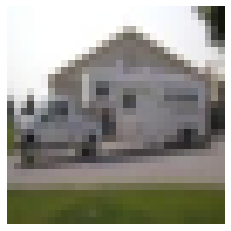

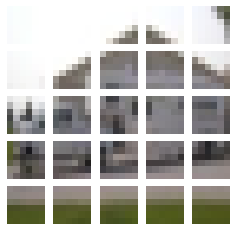

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")
plt.savefig("original.png", dpi=300, bbox_inches="tight")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
plt.savefig("patched.png", dpi=300, bbox_inches="tight")

In [ ]:
#visualizing progress
plt.plot(train.history["loss"], label="train_loss")
plt.plot(train.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
#visualizing progress
plt.plot(train.history["accuracy"], label="accuracy")
plt.plot(train.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

###*Compact Vision Transformer (CVT)*

In [ ]:
# positional_emb = True
# conv_layers = 2
# projection_dim = 128
# patch_size = 6
# num_heads = 2
# transformer_units = [
#     projection_dim,
#     projection_dim,
# ]
# transformer_layers = 2
# stochastic_depth_rate = 0.1
# num_patches = (image_size // patch_size) ** 2
# learning_rate = 0.001
# weight_decay = 0.0001
# batch_size = 128
# num_epochs = 30
# image_size = 32
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 30
image_size = 32 # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
conv_layers = 2
positional_emb = True
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
#tokenizer consists of convolutional layers
#for convolutional tokenization 
# inputs => embed_to_patches/conv_layer=> linear_projection/pooling => reshape

# class Tokenizer(layers.Layer):
#     def __init__(
#         self,
#         kernel_size=3,
#         stride=1,
#         padding=1,
#         pooling_kernel_size=3,
#         pooling_stride=2,
#         num_conv_layers=conv_layers,
#         num_output_channels=[64, 128],
#         positional_emb=positional_emb,
#         **kwargs,
#     ):
#         super(Tokenizer, self).__init__(**kwargs)

#         # convolutional layers
#         self.conv_model = keras.Sequential()
#         for i in range(num_conv_layers):
#             self.conv_model.add(
#                 layers.Conv2D(
#                     num_output_channels[i],
#                     kernel_size,
#                     stride,
#                     padding="valid",
#                     use_bias=False,
#                     activation="relu",
#                     kernel_initializer="he_normal",
#                 )
#             )
            
#             self.conv_model.add(layers.ZeroPadding2D(padding))
#             #linear pooling 
#             self.conv_model.add(
#                 layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
#             )

#         self.positional_emb = positional_emb
        
#     #reshape 
#     def call(self, images):
#         outputs = self.conv_model(images)
#         # After passing the images through our mini-network the spatial dimensions
#         # are flattened to form sequences.
#         reshaped = tf.reshape(
#             outputs,
#             (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
#         )
#         return reshaped

#     #position embedding(optinal)
#     #calculating the number of sequences and initialize an embedding layer which is learned
#     def positional_embedding(self, image_size):
#         # Positional embeddings are optional in CCT. Here, we calculate
#         # the number of sequences and initialize an `Embedding` layer to
#         # compute the positional embeddings later.
#         if self.positional_emb:
#             dummy_inputs = tf.ones((1, image_size, image_size, 3))
#             dummy_outputs = self.call(dummy_inputs)
#             sequence_length = tf.shape(dummy_outputs)[1]
#             projection_dim = tf.shape(dummy_outputs)[-1]


#             embed_layer = layers.Embedding(
#                 input_dim=sequence_length, output_dim=projection_dim
#             )
#             return embed_layer, sequence_length

#             # embed_layer = keras.models.Sequential()

#             # embed_layer.add(TrigPosEmbedding(
#             #     input_dim=sequence_length, 
#             #     output_dim=projection_dim,
#             #     mode = TrigPosEmbedding.MODE_EXPAND,
#             # ))
#             # return embed_layer, sequence_length
#         else:
#             return None

In [ ]:
#transformer with sequence pooling

def transformer(
    image_size = image_size,
    input_shape = input_shape,
    num_heads = num_heads,
    projection_dim = projection_dim,
    transformer_units = transformer_units

):
    inputs = layers.Input(input_shape)
    #data augmentation
    augmented = augmentation(inputs)
    #create patches
    patches = Patches(patch_size)(inputs)
    #enocde patches 
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)


    #adding positional embedding
    # if positional_emb:
    #     embed_layer, seq_len = Tokenizer.positional_embedding(image_size)
    #     positions = tf.range(start=0, limit=seq_len, delta=1)
    #     positional_embeddings = embed_layer(positions)
    #     encoded_patches += positional_embeddings

    #creating layers from transformer block
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=transformer_units, dropout_rate=0.5)
    #sequence pooling
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)
    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



In [ ]:
#model training 
def training(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)
    filepath = "/sample_data/tmp/checkpoint"
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy")
        ],
    )
    es = keras.callbacks.ModelCheckpoint(
        filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = num_epochs, validation_split= 0.1, callbacks = [es])
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

In [ ]:
model = transformer()

In [ ]:
train = training(model)

Epoch 1/30
352/352 [==============================] - 106s 292ms/step - loss: 2.1122 - accuracy: 0.2273 - val_loss: 1.9935 - val_accuracy: 0.2614
Epoch 2/30
352/352 [==============================] - 103s 292ms/step - loss: 1.9549 - accuracy: 0.3007 - val_loss: 1.9024 - val_accuracy: 0.3262
Epoch 3/30
352/352 [==============================] - 104s 294ms/step - loss: 1.8845 - accuracy: 0.3390 - val_loss: 1.8584 - val_accuracy: 0.3454
Epoch 4/30
352/352 [==============================] - 103s 293ms/step - loss: 1.8352 - accuracy: 0.3660 - val_loss: 1.7964 - val_accuracy: 0.3870
Epoch 5/30
352/352 [==============================] - 103s 293ms/step - loss: 1.7934 - accuracy: 0.3920 - val_loss: 1.7833 - val_accuracy: 0.3968
Epoch 6/30
352/352 [==============================] - 103s 293ms/step - loss: 1.7626 - accuracy: 0.4087 - val_loss: 1.7680 - val_accuracy: 0.3994
Epoch 7/30
352/352 [==============================] - 103s 293ms/step - loss: 1.7463 - accuracy: 0.4189 - val_loss: 1.7518 -

ValueError: ignored

In [ ]:
#visualizing progress
plt.plot(train.history["loss"], label="train_loss")
plt.plot(train.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

NameError: ignored

In [ ]:
#visualizing progress
plt.plot(train.history["accuracy"], label="accuracy")
plt.plot(train.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

NameError: ignored

### *Compact Convolutional Transformer (CCT)*

In [ ]:
#tokenizer consists of convolutional layers
#for convolutional tokenization 
# inputs => embed_to_patches/conv_layer=> linear_projection/pooling => reshape
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
image_size = 32
class Tokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(Tokenizer, self).__init__(**kwargs)

        # convolutional layers
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            
            self.conv_model.add(layers.ZeroPadding2D(padding))
            #linear pooling 
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb
        
    #reshape 
    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    #position embedding(optinal)
    #calculating the number of sequences and initialize an embedding layer which is learned
    def positional_embedding(self, image_size):
        # calculating the number of sequences and initialize an embedding layer to
        # compute the positional embeddings later
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]


            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length

            # embed_layer = keras.models.Sequential()

            # embed_layer.add(TrigPosEmbedding(
            #     input_dim=sequence_length, 
            #     output_dim=projection_dim,
            #     mode = TrigPosEmbedding.MODE_EXPAND,
            # ))
            # return embed_layer, sequence_length
        else:
            return None

In [ ]:
#transformer with sequence pooling

def transformer(
    image_size = image_size,
    input_shape = input_shape,
    num_heads = num_heads,
    projection_dim = projection_dim,
    transformer_units = transformer_units

):
    inputs = layers.Input(input_shape)
    #augmentation
    augmented = augmentation(inputs)
    #tokenization and encoding patches
    tokens = Tokenizer()
    encoded_patches = tokens(augmented)

    #adding positional embedding
    if positional_emb:
        embed_layer, seq_len = tokens.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positional_embeddings = embed_layer(positions)
        encoded_patches += positional_embeddings
    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    #creating layers from transformer block

    for i in range(transformer_layers):
        #layer normalization
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        #create a mult-head attention
        attention_output = layers.MultiHeadAttention(num_heads = num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        #skip connection
        x2 = layers.Add()([attention_output, encoded_patches])
        #layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        #skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    #apply sequence pooling
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    

    # Add MLP.
    features = mlp(representation, hidden_units=transformer_units, dropout_rate=0.5)
    #sequence pooling 
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)
    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



In [ ]:
#model training 

def training(model, x_train, y_train):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)
    filepath = "/sample_data/tmp/checkpoint"
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
        ],
    )
    es = keras.callbacks.ModelCheckpoint(
        filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = num_epochs, validation_split= 0.1, callbacks = [es])


    return history


In [ ]:
model = transformer()
train = training(model, x_train, y_train)

In [ ]:
#visualizing progress
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
#visualizing progress
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()